In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import seaborn.objects as so
from sklearn.ensemble import RandomForestClassifier    
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

import toolz


#custom imports
import helpers.functions as fn

train_url = f'https://raw.githubusercontent.com/Mschaid/kg_workflow/main/train.csv'
test_url = f'https://raw.githubusercontent.com/Mschaid/kg_workflow/main/test.csv'

In [98]:
train, test = pd.read_csv(train_url), pd.read_csv(test_url)

In [99]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Sharp decline in survival when parents have more than 2 children, and less than 2 SibSp. 

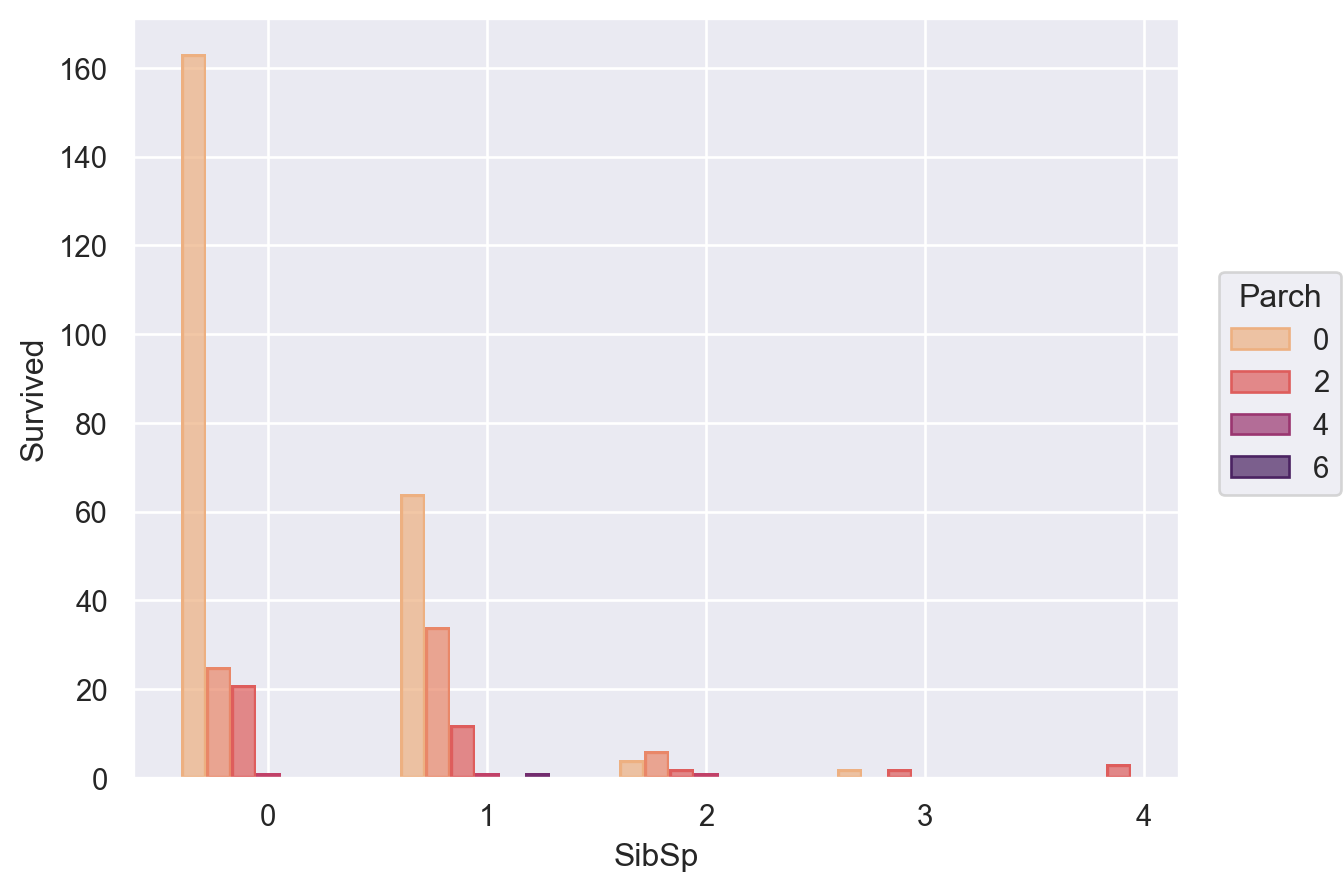

In [100]:

(
    so.Plot(train, x='SibSp', y='Survived', color='Parch')
 .add(so.Bar(), so.Agg('sum'), so.Dodge())
 .scale(color='flare')
#  .facet('Parch', wrap=2)
 )

In [101]:
def process_data(df):
    dum_cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    return(df
           .pipe(fn.process_missing)
           .pipe(fn.process_age)
           .pipe(fn.process_fare)
           .pipe(fn.process_cabin)
           .pipe(fn.process_titles)
           .pipe(fn.small_fam)
           .pipe(fn.create_dummies, column_name=dum_cols)
           .drop(columns  = ['Age', 'SibSp', 'Parch', 
                             'Fare', 'Title_Miss', 'Title_Mr', 
                             'Title_Mrs','Sex_male'])
           )

 
process_train, process_test = process_data(train), process_data(test)
 

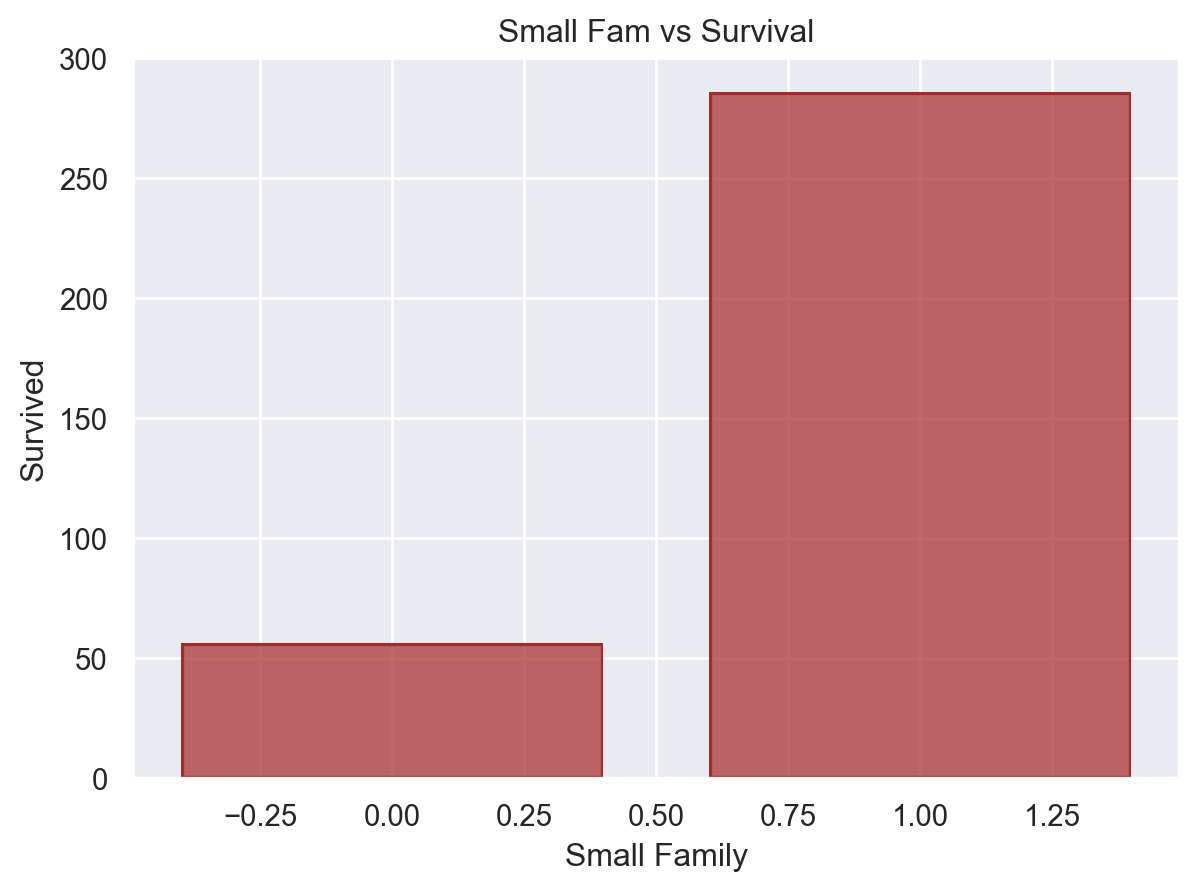

In [102]:

(
    so.Plot(process_train, x='small_fam', y='Survived')
 .add(so.Bar(color = 'brown'), so.Agg('sum'), so.Dodge()) 
 .label(title='Small Fam vs Survival', x ='Small Family')
 )

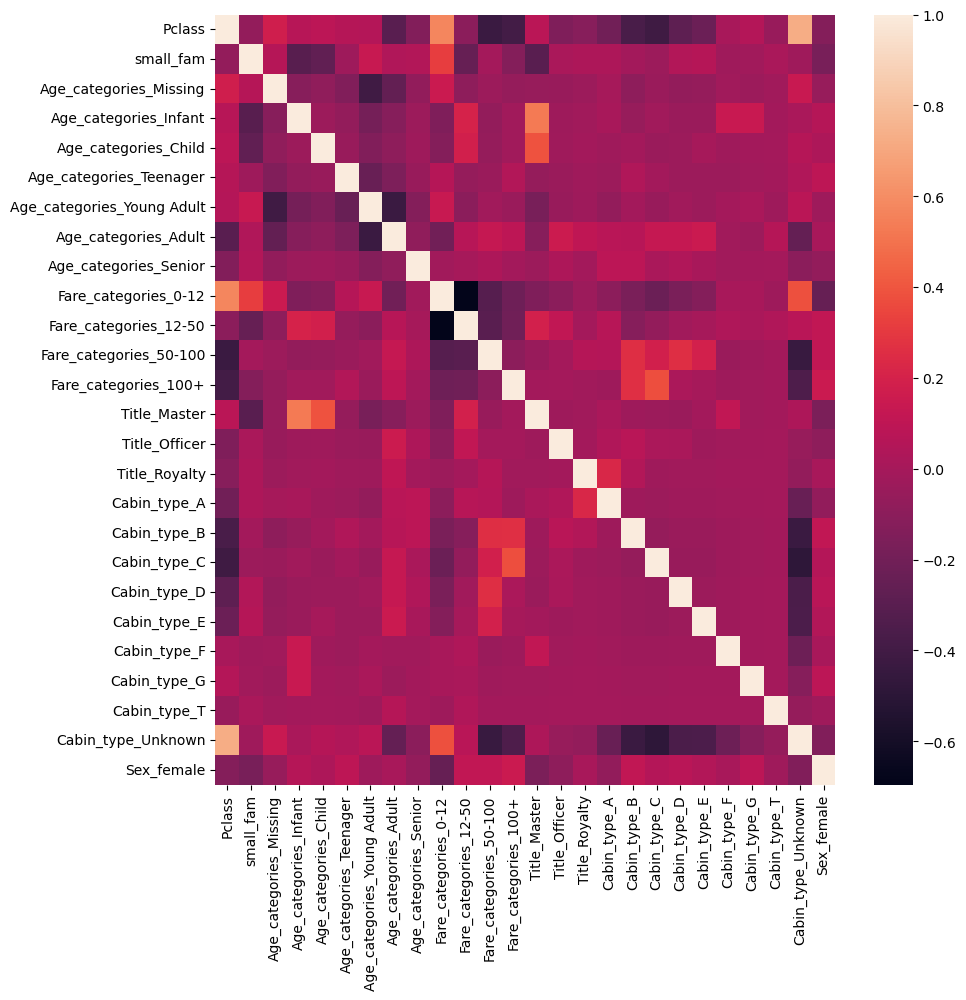

In [103]:
train_corr = process_train.drop(columns=['PassengerId', 'Survived']).corr(numeric_only = True)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train_corr, ax=ax)
plt.show()

## collinearity looks <u>OK</u>

will experiment with modeling further before dropping more columns

In [104]:
def feature_selection(df):
    
    df = df.select_dtypes('number').dropna()
    all_X = df.drop(columns = ['PassengerId','Survived'])
    all_y = df['Survived']
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(estimator=rf, cv = 10).fit(all_X, all_y)
    return all_X.columns[selector.support_]
 
    

In [105]:
selected_features = feature_selection(process_train)


## Model experimentation 
Comparing 

three models : logistic regression, KNN classifer, and random forest classifer
Using 10 K-fold gird search with various hyperparameters we will test various methods

In [114]:

models  = [
        {
                'name':'LogisticRegression',
                'estimator': LogisticRegression(),
                'hyperparameters':
                        {
                        'solver':['newton-cg', 'lbfgs', 'liblinear']
                        }
        },
                
        {
                'name':'KNeighborsClassifier',
                'estimator': KNeighborsClassifier(),
                'hyperparameters':{
                        'n_neighbors':range(1,20,2),
                        'weights': ['distance','uniform'],
                        'algorithm':['ball_tree', 'kd_tree', 'brute'],
                        'p':[1,2]
                }
        },
        {
                'name': 'RandomForestClassifier',
                'estimator': RandomForestClassifier(),
                'hyperparameters':
                        {
                                'n_estimators':[4,6,9],
                                'criterion': ['entropy', 'gini'],
                                'max_depth': [2,5,10],
                                'max_features': ['log2','sqrt'], 
                                'min_samples_leaf': [1,5,8],
                                'min_samples_split':[2,3,5]
                        }
        }
        ]

def grid_search(df,features, target, model):
 # set x and y from features and target
    all_X  =  df[features]
    all_y = df[target]
    
 #grid search  
    grid = GridSearchCV(estimator = model['estimator'], param_grid = model['hyperparameters'],cv = 10)
    grid.fit(all_X, all_y)
    model['best_estimator'] = grid.best_params_
    model['best_score'] = grid.best_score_ 
    model['best_model'] = grid.best_estimator_


In [115]:

for model in models:
    grid_search(df = process_train, features = selected_features, target = 'Survived', model = model)

In [116]:
models 

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_estimator': {'solver': 'liblinear'},
  'best_score': 0.8114856429463171,
  'best_model': LogisticRegression(solver='liblinear')},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(),
  'hyperparameters': {'n_neighbors': range(1, 20, 2),
   'weights': ['distance', 'uniform'],
   'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'p': [1, 2]},
  'best_estimator': {'algorithm': 'ball_tree',
   'n_neighbors': 11,
   'p': 1,
   'weights': 'distance'},
  'best_score': 0.8304993757802747,
  'best_model': KNeighborsClassifier(algorithm='ball_tree', n_neighbors=11, p=1,
                       weights='distance')},
 {'name': 'RandomForestClassifier',
  'estimator': RandomForestClassifier(),
  'hyperparameters': {'n_estimators': [4, 6, 9],
   'criterion': ['entropy', 'gini'],
   'max_depth': [2, 5, 10],
   'max_features': ['log2', '

## Results

Random forest classifer performed the best witn a accuracy score of 0.835
best parameters are
   criterion': 'gini',
   'max_depth': 10,
   'max_features': 'log2',
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 9 

In [123]:
def save_submission_file(train_model, df,features, id_col, target):
    prediction = train_model.predict(df[features])
    results = pd.DataFrame(
        { 
                 id_col:df[id_col], 
                 target: prediction
                 }

    )
    # results.to_csv('submission.csv') 
    return results

In [125]:
save_submission_file(models[2]['best_model'], df = process_test, id_col = 'PassengerId', features = selected_features, target = 'Survived')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [121]:
process_test

,PassengerId,Pclass,Name,Sex,Ticket,Embarked,Age_categories,Fare_categories,Cabin_type,Title,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female
0,892,3,"Kelly, Mr. James",male,330911,Q,Young Adult,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,363272,S,Adult,0-12,Unknown,Mrs,...,0,0,0,0,0,0,0,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,240276,Q,Senior,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
3,895,3,"Wirz, Mr. Albert",male,315154,S,Young Adult,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,3101298,S,Young Adult,12-50,Unknown,Mrs,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,A.5. 3236,S,Missing,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,PC 17758,C,Adult,100+,C,Royalty,...,1,0,0,1,0,0,0,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,SOTON/O.Q. 3101262,S,Adult,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
416,1308,3,"Ware, Mr. Frederick",male,359309,S,Missing,0-12,Unknown,Mr,...,0,0,0,0,0,0,0,0,1,0
